https://github.com/TeamHG-Memex/sklearn-crfsuite/blob/master/docs/CoNLL2002.ipynb

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
from itertools import chain

import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import RandomizedSearchCV

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Будем использовать данные из FactRuEval

In [3]:
test_file = '/NLP/data/factRuEval-2016-master/factRuEval_train.conll'
train_file = '/NLP/data/factRuEval-2016-master/factRuEval_test.conll'

In [4]:
%%time
from nltk.corpus.reader.conll import *
train_reader = ConllCorpusReader(root = '', fileids = [train_file], columntypes = ['ignore', 'ignore', 'words', 'pos', 'chunk'])
test_reader = ConllCorpusReader(root = '', fileids = [test_file], columntypes = ['ignore', 'ignore', 'words', 'pos', 'chunk'])


train_sents = list(train_reader.iob_sents())
test_sents = list(test_reader.iob_sents())

print(len(train_sents))
print(len(test_sents))

3138
1769
CPU times: user 1.58 s, sys: 88.6 ms, total: 1.67 s
Wall time: 1.72 s


In [5]:
train_sents[0]

[('Александр', 'NOUN', 'B-Person'),
 ('Вертинский', 'NOUN', 'E-Person'),
 ('.', 'Other', 'O'),
 ('«', 'Other', 'O'),
 ('Я', 'NPRO', 'O'),
 ('не', 'PRCL', 'O'),
 ('знать', 'VERB', 'O'),
 (',', 'Other', 'O'),
 ('зачем', 'ADVB', 'O'),
 ('и', 'CONJ', 'O'),
 ('кома', 'NOUN', 'O'),
 ('это', 'PRCL', 'O'),
 ('нужно', 'PRED', 'O'),
 ('…', 'Other', 'O'),
 ('»', 'Other', 'O')]

## Признаковое пространство 

In [6]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,   
        'word[-3:]': word[-3:],
        'word[:3]': word[:3].lower(),
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:word[-3:]': word[-3:],
            '-1:word[:3]': word[:3].lower(),
        })
    else:
        features['BOS'] = True
        
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:word[-3:]': word[-3:],
            '+1:word[:3]': word[:3].lower(),
        })
    else:
        features['EOS'] = True
                
    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

И вот что получится

In [7]:
sent2features(train_sents[0])[1]

{'+1:postag': 'Other',
 '+1:word.istitle()': False,
 '+1:word.isupper()': False,
 '+1:word.lower()': '.',
 '+1:word[-3:]': 'кий',
 '+1:word[:3]': 'вер',
 '-1:postag': 'NOUN',
 '-1:word.istitle()': True,
 '-1:word.isupper()': False,
 '-1:word.lower()': 'александр',
 '-1:word[-3:]': 'кий',
 '-1:word[:3]': 'вер',
 'bias': 1.0,
 'postag': 'NOUN',
 'word.isdigit()': False,
 'word.istitle()': True,
 'word.isupper()': False,
 'word.lower()': 'вертинский',
 'word[-3:]': 'кий',
 'word[:3]': 'вер'}

Извлекаем признаки из данных

In [8]:
%%time
X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]

CPU times: user 488 ms, sys: 52.3 ms, total: 540 ms
Wall time: 551 ms


## Обучение


In [9]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    c1=0.1, 
    c2=0.1, 
    max_iterations=100, 
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

CPU times: user 14.6 s, sys: 191 ms, total: 14.8 s
Wall time: 15.3 s


## Оценка качества


In [10]:
labels = list(crf.classes_)
labels.remove('O')
labels

['B-Person',
 'E-Person',
 'B-Location',
 'E-Location',
 'I-Person',
 'B-Org',
 'E-Org',
 'B-LocOrg',
 'I-Org',
 'I-Location',
 'E-LocOrg',
 'I-LocOrg',
 'B-Project',
 'E-Project',
 'I-Project',
 'E-Facility',
 'B-Facility']

In [11]:
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred, 
                      average='micro', labels=labels)

0.62385321100917424

Inspect per-class results in more detail:

In [12]:
# group B and I results
sorted_labels = sorted(
    labels, 
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

             precision    recall  f1-score   support

 B-Facility      0.000     0.000     0.000         0
 E-Facility      0.000     0.000     0.000         0
   B-LocOrg      0.672     0.508     0.578       512
   E-LocOrg      0.400     0.071     0.121        28
   I-LocOrg      0.000     0.000     0.000         5
 B-Location      0.732     0.582     0.649       512
 E-Location      0.259     0.095     0.139        74
 I-Location      0.000     0.000     0.000        20
      B-Org      0.564     0.454     0.503       705
      E-Org      0.271     0.153     0.196       314
      I-Org      0.160     0.049     0.075        81
   B-Person      0.761     0.828     0.793       739
   E-Person      0.875     0.934     0.903       485
   I-Person      0.125     0.111     0.118        18
  B-Project      0.000     0.000     0.000         2
  E-Project      0.000     0.000     0.000         0
  I-Project      0.000     0.000     0.000         0

avg / total      0.639     0.574     0.598  

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## Оптимизация гиперпараметров


In [13]:
%%time
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    max_iterations=100, 
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score, 
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space, 
                        cv=3, 
                        verbose=1, 
                        n_jobs=-1, 
                        n_iter=5, 
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no

CPU times: user 20.7 s, sys: 573 ms, total: 21.3 s
Wall time: 1min 26s


Best result:

In [14]:
crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.29748780365969646, 'c2': 0.013319147902357026}
best CV score: 0.6191399418239109
model size: 0.80M


### Анализ пространства параметров


Dark blue => 0.6066, dark red => 0.6191


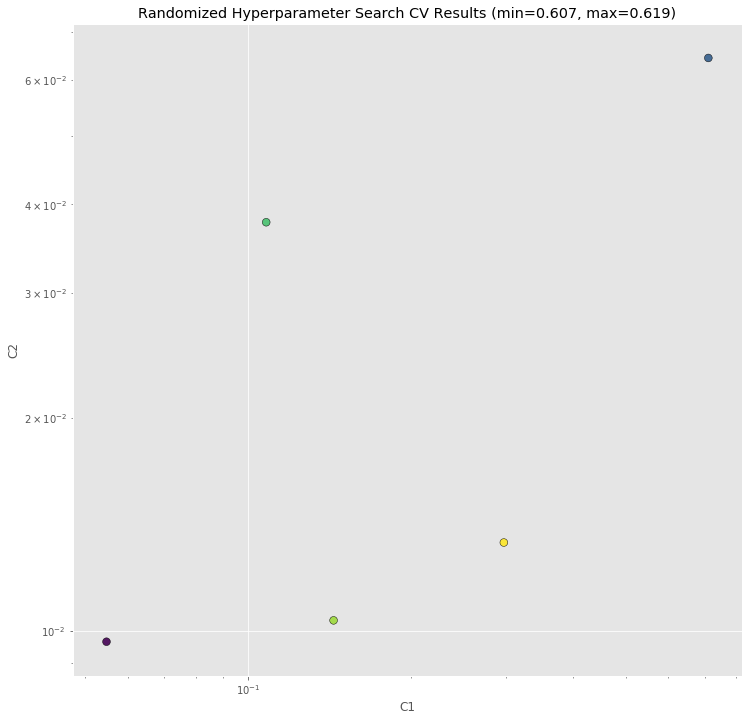

In [15]:
_x = [s.parameters['c1'] for s in rs.grid_scores_]
_y = [s.parameters['c2'] for s in rs.grid_scores_]
_c = [s.mean_validation_score for s in rs.grid_scores_]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

## Лучшие результаты


In [16]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

             precision    recall  f1-score   support

 B-Facility      0.000     0.000     0.000         0
 E-Facility      0.000     0.000     0.000         0
   B-LocOrg      0.678     0.521     0.589       512
   E-LocOrg      0.250     0.036     0.062        28
   I-LocOrg      0.333     0.200     0.250         5
 B-Location      0.744     0.602     0.665       512
 E-Location      0.281     0.122     0.170        74
 I-Location      0.000     0.000     0.000        20
      B-Org      0.532     0.454     0.490       705
      E-Org      0.270     0.153     0.195       314
      I-Org      0.238     0.062     0.098        81
   B-Person      0.731     0.811     0.769       739
   E-Person      0.873     0.903     0.888       485
   I-Person      0.136     0.167     0.150        18
  B-Project      0.000     0.000     0.000         2
  E-Project      0.000     0.000     0.000         0
  I-Project      0.000     0.000     0.000         0

avg / total      0.630     0.572     0.593  

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [17]:
metrics.flat_f1_score(y_test, y_pred, 
                      average='weighted', labels=labels)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.59342700669673254

## Что выучил классификатор

In [18]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
I-Person -> E-Person 5.482649
E-LocOrg -> I-LocOrg 5.417368
B-Project -> E-Project 5.275057
E-Location -> B-Location 4.763166
B-Person -> I-Person 4.412832
B-Project -> I-Project 4.335189
E-Location -> I-Location 4.068301
B-Person -> E-Person 4.022025
B-Location -> E-Location 3.806184
I-Location -> E-Location 3.544069
E-Facility -> B-Facility 3.281636
E-LocOrg -> B-LocOrg 3.150803
B-LocOrg -> E-LocOrg 3.057096
I-Project -> E-Project 3.028744
O      -> O       3.016195
E-Org  -> I-Org   2.709462
B-Org  -> E-Org   2.626802
I-Location -> B-Location 2.454266
I-Org  -> E-Org   2.348415
E-Org  -> B-Org   2.067930

Top unlikely transitions:
B-Person -> I-Org   -1.161165
E-Facility -> O       -1.243180
B-Org  -> E-Person -1.276976
I-Org  -> B-Location -1.335737
O      -> B-Facility -1.337770
I-Person -> O       -1.384699
B-Location -> B-Person -1.498815
B-Location -> B-LocOrg -1.527148
I-Org  -> B-Person -1.609982
O      -> E-Project -1.639936
O      -> I-LocOrg -1.7837

In [19]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))    

print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])

Top positive:
10.861481 O        word.lower():медиа
8.535608 B-Person -1:word.lower():аккаунт
8.527615 O        -1:word.lower():попечительский
6.983420 B-Org    word.lower():завод
6.489342 B-Project -1:word.lower():выпускать
5.967563 E-Person -1:word.lower():.
5.951762 B-LocOrg +1:word.lower():кэсоня
5.949668 B-Org    word.lower():парламент
5.907110 I-Person -1:word.lower():.
5.905557 B-LocOrg +1:word.lower():республика
5.825266 I-Org    word.lower():росгеология
5.744586 E-Org    +1:word.lower():ab
5.735714 E-Org    word.lower():живить
5.673415 E-Person +1:word.lower():бодхидхарма
5.637777 E-Org    word.lower():правящий
5.636812 B-Location +1:word.lower():негосударственный
5.498705 B-Org    word.lower():рамблер-новость
5.475754 E-Location -1:word.lower():остров
5.473388 O        postag:NPRO
5.274109 B-Person word.istitle()
5.245138 B-Location +1:word.lower():исполнитель
5.241363 B-Org    word.lower():newsru.com
5.161456 I-LocOrg -1:word.lower():автономный
5.091439 I-Org    +1:word.lowe